In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras


import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import run_model as rm
import eval_model as ev

2023-04-11 03:47:47.521557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 03:47:49.491552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [4]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [5]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [6]:
metadata = pd.read_csv('train.csv')

# Trasfer learning from ImageNet

### Image Resolution 256 x 256

In [7]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 6, 6, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 6, 6, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 6, 6, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [9]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [34]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [35]:
BATCH_SIZE = 4*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [9]:
print(len(train_gen), len(val_gen))

218 54


In [10]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 256, 256, 3) (128,)


In [11]:
inception.output.shape[-3:]

TensorShape([6, 6, 2048])

## Out of the box

In [16]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 01:16:09.643346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1139 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4764 - prc: 0.0196

2023-04-07 01:20:53.664993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.10785, saving model to models/inception_imagenet_checkpoint/imagenet_sgd-lr-default-01-prc0.02-tp0.0-loss0.11.hdf5
218/218 [==============================] - 369s 2s/step - loss: 0.1139 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4764 - prc: 0.0196 - val_loss: 0.1078 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4550 - val_prc: 0.0178
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4871 - prc: 0.0201
Epoch 2: val_loss improved from 0.10785 to 0.10676, saving model to models/inception_imagenet_checkpoint/imagenet_sgd-lr-default-02-prc0.02-tp0.0-loss0.11.hdf5
218/21

218/218 [==============================] - ETA: 0s - loss: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5138 - prc: 0.0218
Epoch 12: val_loss did not improve from 0.10339
218/218 [==============================] - 354s 2s/step - loss: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5138 - prc: 0.0218 - val_loss: 0.1088 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4558 - val_prc: 0.0178
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.1011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5180 - prc: 0.0219
Epoch 13: val_loss did not improve from 0.10339
21

Process Keras_worker_ForkPoolWorker-1717:
Process Keras_worker_ForkPoolWorker-1724:
Process Keras_worker_ForkPoolWorker-1714:
Process Keras_worker_ForkPoolWorker-1722:
Process Keras_worker_ForkPoolWorker-1726:
Process Keras_worker_ForkPoolWorker-1705:
Process Keras_worker_ForkPoolWorker-1697:
Process Keras_worker_ForkPoolWorker-1715:
Process Keras_worker_ForkPoolWorker-1719:
Process Keras_worker_ForkPoolWorker-1728:
Process Keras_worker_ForkPoolWorker-1713:
Process Keras_worker_ForkPoolWorker-1725:
Process Keras_worker_ForkPoolWorker-1721:
Process Keras_worker_ForkPoolWorker-1718:
Process Keras_worker_ForkPoolWorker-1723:
Process Keras_worker_ForkPoolWorker-1727:
Process Keras_worker_ForkPoolWorker-1716:
Process Keras_worker_ForkPoolWorker-1720:
Process Keras_worker_ForkPoolWorker-1710:
Process Keras_worker_ForkPoolWorker-1712:
Process Keras_worker_ForkPoolWorker-1709:
Process Keras_worker_ForkPoolWorker-1711:
Traceback (most recent call last):


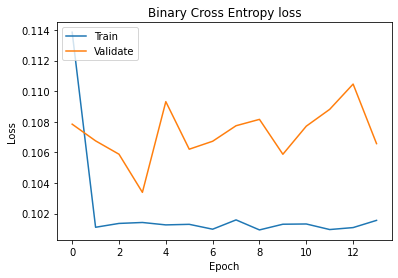

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias

In [9]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [10]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '.../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 03:08:50.404335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1166 - tp: 3.0000 - fp: 125.0000 - tn: 33966.0000 - fn: 722.0000 - accuracy: 0.9757 - precision: 0.0234 - recall: 0.0041 - auc: 0.4947 - prc: 0.0204

2023-04-07 03:13:36.747644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.11354, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_sgd-lr-default-01-prc0.02-tp0.0-loss0.11.hdf5
218/218 [==============================] - 372s 2s/step - loss: 0.1166 - tp: 3.0000 - fp: 125.0000 - tn: 33966.0000 - fn: 722.0000 - accuracy: 0.9757 - precision: 0.0234 - recall: 0.0041 - auc: 0.4947 - prc: 0.0204 - val_loss: 0.1135 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4675 - val_prc: 0.0186
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4997 - prc: 0.0206
Epoch 2: val_loss improved from 0.11354 to 0.11163, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_sgd-lr-default-02-prc0.02-tp0.0-loss0.11.hdf5
21

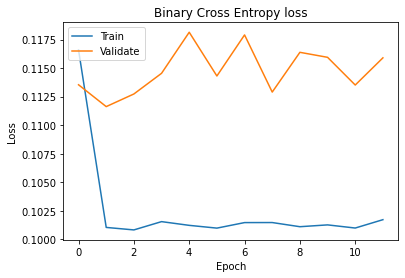

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias and class weight

In [14]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [11]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [25]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_6 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weight_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-07 04:40:38.247705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4615 - tp: 301.0000 - fp: 14163.0000 - tn: 13161.0000 - fn: 279.0000 - accuracy: 0.4824 - precision: 0.0208 - recall: 0.5190 - auc: 0.5013 - prc: 0.0210

2023-04-07 04:45:34.521627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.39952, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weight_sgd-lr-default-01-prc0.02-tp2.0-loss0.40.hdf5
218/218 [==============================] - 388s 2s/step - loss: 0.4615 - tp: 301.0000 - fp: 14163.0000 - tn: 13161.0000 - fn: 279.0000 - accuracy: 0.4824 - precision: 0.0208 - recall: 0.5190 - auc: 0.5013 - prc: 0.0210 - val_loss: 0.3995 - val_tp: 2.0000 - val_fp: 101.0000 - val_tn: 6670.0000 - val_fn: 139.0000 - val_accuracy: 0.9653 - val_precision: 0.0194 - val_recall: 0.0142 - val_auc: 0.4826 - val_prc: 0.0190
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4667 - tp: 279.0000 - fp: 13033.0000 - tn: 14292.0000 - fn: 300.0000 - accuracy: 0.5222 - precision: 0.0210 - recall: 0.4819 - auc: 0.5032 - prc: 0.0215
Epoch 2: val_loss did not improve from 0.39952
218/218 [==============================] - 372s 2s/step - loss: 0.4667 - tp: 279.0000 - fp: 13033.0000 - tn: 14292.0000 - fn: 300.0000 - 

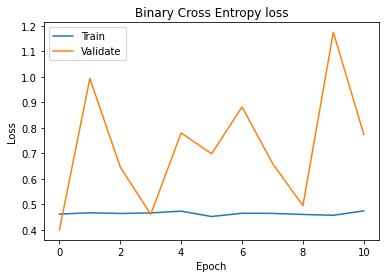

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

### Increased learning rate

In [23]:
LEARNING_RATE = 0.01
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-07 23:59:19.275901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4667 - tp: 300.0000 - fp: 14419.0000 - tn: 19676.0000 - fn: 421.0000 - accuracy: 0.5738 - precision: 0.0204 - recall: 0.4161 - auc: 0.4836 - prc: 0.0200

2023-04-08 00:04:18.461631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.58632, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-2-01-prc0.02-tp37.0-loss0.59.hdf5
218/218 [==============================] - 389s 2s/step - loss: 0.4667 - tp: 300.0000 - fp: 14419.0000 - tn: 19676.0000 - fn: 421.0000 - accuracy: 0.5738 - precision: 0.0204 - recall: 0.4161 - auc: 0.4836 - prc: 0.0200 - val_loss: 0.5863 - val_tp: 37.0000 - val_fp: 1693.0000 - val_tn: 5077.0000 - val_fn: 105.0000 - val_accuracy: 0.7399 - val_precision: 0.0214 - val_recall: 0.2606 - val_auc: 0.4865 - val_prc: 0.0201
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4557 - tp: 267.0000 - fp: 13045.0000 - tn: 14282.0000 - fn: 310.0000 - accuracy: 0.5214 - precision: 0.0201 - recall: 0.4627 - auc: 0.4993 - prc: 0.0205
Epoch 2: val_loss improved from 0.58632 to 0.55309, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-2-02-prc0.02-tp28.0-loss0.55.hdf5
218/218 [=

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4702 - tp: 276.0000 - fp: 13548.0000 - tn: 13775.0000 - fn: 305.0000 - accuracy: 0.5035 - precision: 0.0200 - recall: 0.4750 - auc: 0.4927 - prc: 0.0202
Epoch 13: val_loss improved from 0.28786 to 0.15161, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-2-13-prc0.02-tp0.0-loss0.15.hdf5
218/218 [==============================] - 372s 2s/step - loss: 0.4702 - tp: 276.0000 - fp: 13548.0000 - tn: 13775.0000 - fn: 305.0000 - accuracy: 0.5035 - precision: 0.0200 - recall: 0.4750 - auc: 0.4927 - prc: 0.0202 - val_loss: 0.1516 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4708 - val_prc: 0.0193
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4815 - tp: 290.0000 - fp: 14046.0000 - tn: 13279.0000 - fn: 289.0000 - accuracy: 0.4863 - prec

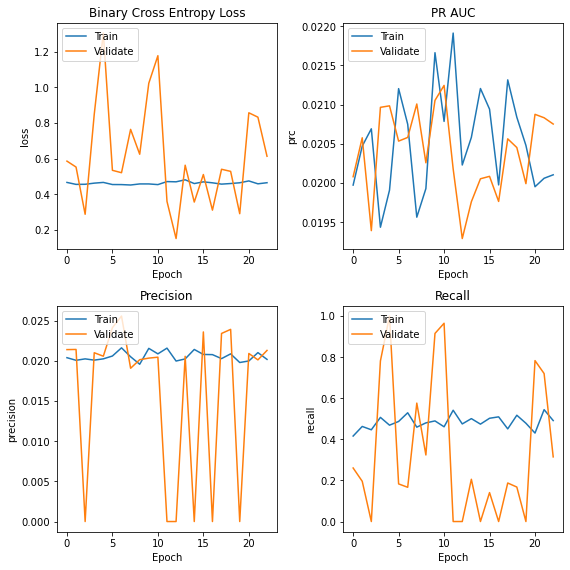

In [25]:
ev.plot_history(history)

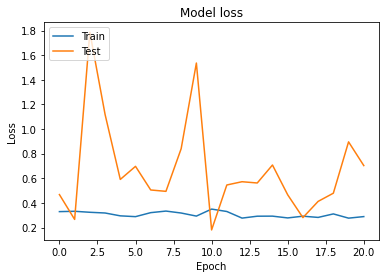

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Decrease learning rate

In [20]:
LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 03:03:35.272353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 418.0000 - fp: 19678.0000 - tn: 7646.0000 - fn: 162.0000 - accuracy: 0.2890 - precision: 0.0208 - recall: 0.7207 - auc: 0.4918 - prc: 0.0199

2023-04-09 03:08:34.563595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.56003, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-4-01-prc0.02-tp31.0-loss0.56.hdf5
218/218 [==============================] - 388s 2s/step - loss: 0.4396 - tp: 418.0000 - fp: 19678.0000 - tn: 7646.0000 - fn: 162.0000 - accuracy: 0.2890 - precision: 0.0208 - recall: 0.7207 - auc: 0.4918 - prc: 0.0199 - val_loss: 0.5600 - val_tp: 31.0000 - val_fp: 1353.0000 - val_tn: 5416.0000 - val_fn: 112.0000 - val_accuracy: 0.7880 - val_precision: 0.0224 - val_recall: 0.2168 - val_auc: 0.4910 - val_prc: 0.0206
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4393 - tp: 66.0000 - fp: 2622.0000 - tn: 24703.0000 - fn: 513.0000 - accuracy: 0.8877 - precision: 0.0246 - recall: 0.1140 - auc: 0.5040 - prc: 0.0215
Epoch 2: val_loss did not improve from 0.56003
218/218 [==============================] - 372s 2s/step - loss: 0.4393 - tp: 66.0000 - fp: 2622.0000 - tn: 24703.0000 - fn: 513.0000 - accur

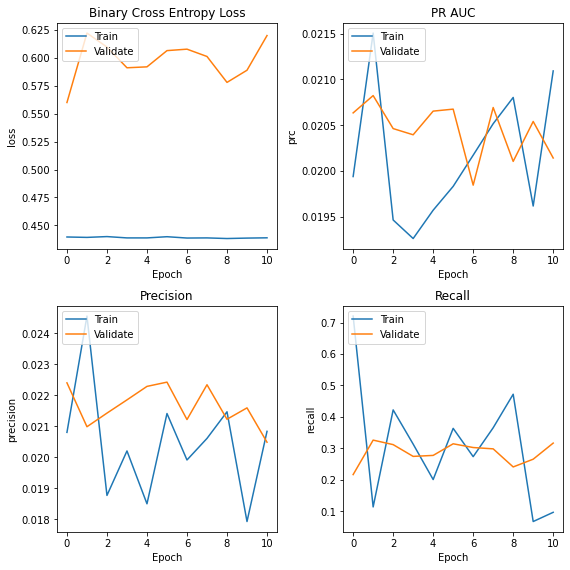

In [22]:
ev.plot_history(history)

### Decreasing batch size from 4 x 32 to 1 x 32

In [29]:
BATCH_SIZE = 1*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [32]:
LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_8 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch32_sgd-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 07:35:01.695799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 0.4394 - tp: 323.0000 - fp: 14148.0000 - tn: 20041.0000 - fn: 400.0000 - accuracy: 0.5833 - precision: 0.0223 - recall: 0.4467 - auc: 0.5134 - prc: 0.0219

2023-04-09 07:39:31.897627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.80387, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch32_sgd-lr1e-4-01-prc0.02-tp91.0-loss0.80.hdf5
875/875 [==============================] - 349s 385ms/step - loss: 0.4394 - tp: 323.0000 - fp: 14148.0000 - tn: 20041.0000 - fn: 400.0000 - accuracy: 0.5833 - precision: 0.0223 - recall: 0.4467 - auc: 0.5134 - prc: 0.0219 - val_loss: 0.8039 - val_tp: 91.0000 - val_fp: 4433.0000 - val_tn: 2368.0000 - val_fn: 52.0000 - val_accuracy: 0.3541 - val_precision: 0.0201 - val_recall: 0.6364 - val_auc: 0.4880 - val_prc: 0.0221
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 0.4403 - tp: 269.0000 - fp: 13043.0000 - tn: 14376.0000 - fn: 312.0000 - accuracy: 0.5230 - precision: 0.0202 - recall: 0.4630 - auc: 0.4900 - prc: 0.0199
Epoch 2: val_loss improved from 0.80387 to 0.75376, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch32_sgd-lr1e-4-02-prc0.02-tp77.0-loss0.

>>> Training time:  4164.389436483383


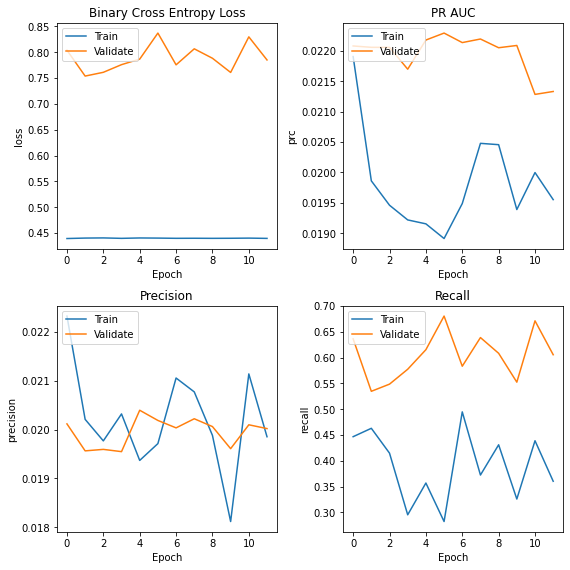

In [34]:
ev.plot_history(history)

### Decrease learning rate to 1e-5

In [20]:
LEARNING_RATE = 0.00001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-07 08:41:39.749896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4591 - tp: 577.0000 - fp: 27327.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.5088 - prc: 0.0209

2023-04-07 08:46:33.128111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.22999, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-5-01-prc0.03-tp143.0-loss1.23.hdf5
218/218 [==============================] - 383s 2s/step - loss: 0.4591 - tp: 577.0000 - fp: 27327.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.5088 - prc: 0.0209 - val_loss: 1.2300 - val_tp: 143.0000 - val_fp: 6747.0000 - val_tn: 22.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0239 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5463 - val_prc: 0.0253
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4503 - tp: 578.0000 - fp: 27326.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4764 - prc: 0.0199
Epoch 2: val_loss improved from 1.22999 to 1.14094, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-5-02-prc0.03-tp143.0-loss1.14.hdf5
218

218/218 [==============================] - ETA: 0s - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 21: val_loss did not improve from 0.90669
218/218 [==============================] - 442s 2s/step - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.9095 - val_tp: 131.0000 - val_fp: 5994.0000 - val_tn: 775.0000 - val_fn: 12.0000 - val_accuracy: 0.1311 - val_precision: 0.0214 - val_recall: 0.9161 - val_auc: 0.5388 - val_prc: 0.0244
Epoch 22/100
218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 22: val_loss did not improve from 0.90669
218/218 [======

In [21]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-07 22:49:25.158353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5053 - prc: 0.0210

2023-04-07 22:54:18.191629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.55928, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-5-01-prc0.02-tp31.0-loss0.56.hdf5
218/218 [==============================] - 385s 2s/step - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5053 - prc: 0.0210 - val_loss: 0.5593 - val_tp: 31.0000 - val_fp: 1342.0000 - val_tn: 5427.0000 - val_fn: 112.0000 - val_accuracy: 0.7896 - val_precision: 0.0226 - val_recall: 0.2168 - val_auc: 0.4876 - val_prc: 0.0205
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4964 - prc: 0.0206
Epoch 2: val_loss did not improve from 0.55928
218/218 [==============================] - 371s 2s/step - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.

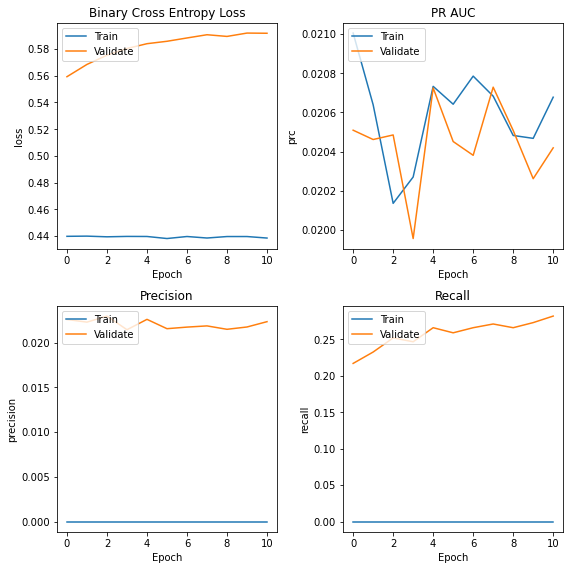

In [22]:
ev.plot_history(history)

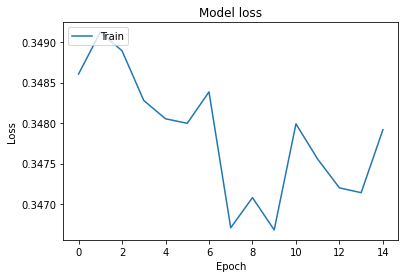

In [31]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Increase batch size from 4 x 32 to 8 x 32

In [21]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [22]:
LEARNING_RATE = 0.00001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-11 05:32:14.866226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4425 - tp: 22.0000 - fp: 1181.0000 - tn: 32914.0000 - fn: 699.0000 - accuracy: 0.9460 - precision: 0.0183 - recall: 0.0305 - auc: 0.4954 - prc: 0.0205

2023-04-11 05:37:52.347375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.56835, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_sgd-lr1e-5-01-prc0.02-tp27.0-loss0.57.hdf5
109/109 [==============================] - 458s 4s/step - loss: 0.4425 - tp: 22.0000 - fp: 1181.0000 - tn: 32914.0000 - fn: 699.0000 - accuracy: 0.9460 - precision: 0.0183 - recall: 0.0305 - auc: 0.4954 - prc: 0.0205 - val_loss: 0.5683 - val_tp: 27.0000 - val_fp: 1328.0000 - val_tn: 5441.0000 - val_fn: 116.0000 - val_accuracy: 0.7911 - val_precision: 0.0199 - val_recall: 0.1888 - val_auc: 0.4560 - val_prc: 0.0193
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4414 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4930 - prc: 0.0204
Epoch 2: val_loss did not improve from 0.56835
109/109 [==============================] - 425s 4s/step - loss: 0.4414 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.000

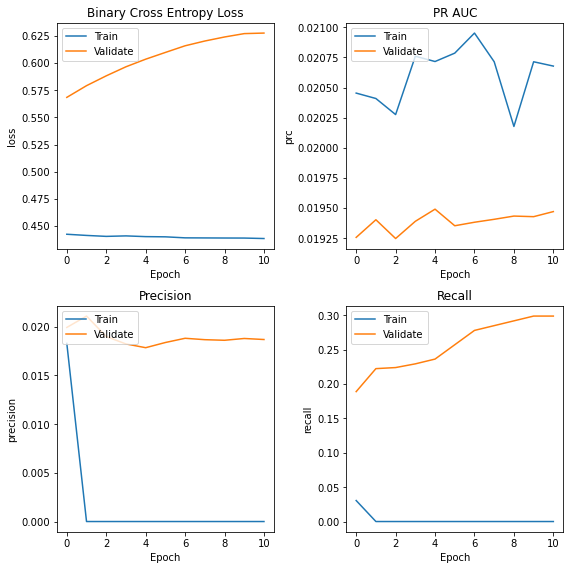

In [24]:
ev.plot_history(history)

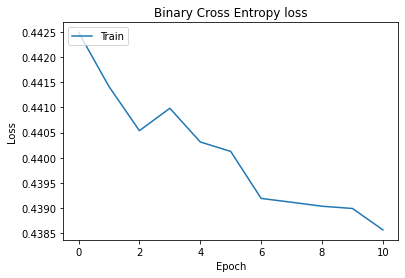

In [25]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

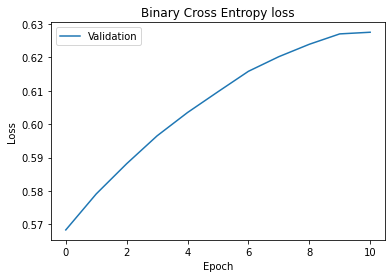

In [26]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Reduce batch size to 2 x 32

In [27]:
BATCH_SIZE = 2*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [28]:
LEARNING_RATE = 0.00001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [29]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_64_bias_weights_batch256_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-11 07:26:04.654937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


437/437 [==============================] - ETA: 0s - loss: 0.4392 - tp: 43.0000 - fp: 2258.0000 - tn: 31898.0000 - fn: 681.0000 - accuracy: 0.9157 - precision: 0.0187 - recall: 0.0594 - auc: 0.4846 - prc: 0.0200

2023-04-11 07:32:02.134985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.63540, saving model to models/inception_imagenet_checkpoint/imagenet_64_bias_weights_batch256_sgd-lr1e-5-01-prc0.02-tp45.0-loss0.64.hdf5
437/437 [==============================] - 448s 981ms/step - loss: 0.4392 - tp: 43.0000 - fp: 2258.0000 - tn: 31898.0000 - fn: 681.0000 - accuracy: 0.9157 - precision: 0.0187 - recall: 0.0594 - auc: 0.4846 - prc: 0.0200 - val_loss: 0.6354 - val_tp: 45.0000 - val_fp: 2408.0000 - val_tn: 4362.0000 - val_fn: 97.0000 - val_accuracy: 0.6376 - val_precision: 0.0183 - val_recall: 0.3169 - val_auc: 0.4619 - val_prc: 0.0194
Epoch 2/100
437/437 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27388.0000 - fn: 580.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4915 - prc: 0.0200
Epoch 2: val_loss did not improve from 0.63540
437/437 [==============================] - 350s 769ms/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27388

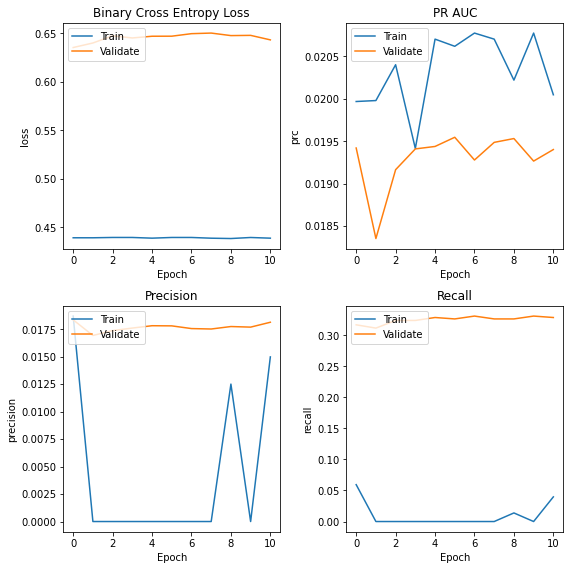

In [30]:
ev.plot_history(history)

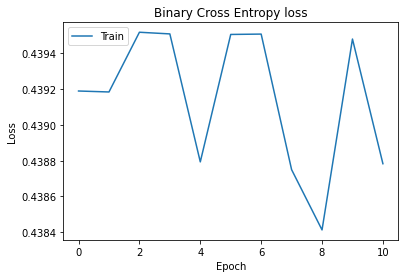

In [31]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

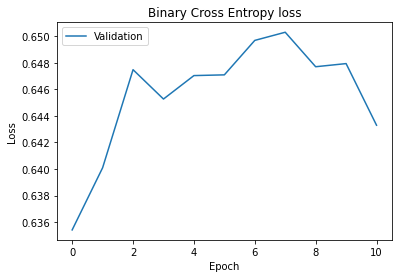

In [32]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Decrease learning rate further to 1e-6

In [16]:
LEARNING_RATE = 0.000001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-38-prc0.02-tp42.0-loss0.60.hdf5')

In [ ]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-08 09:14:23.908059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4400 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5000 - prc: 0.0208
Epoch 1: val_loss improved from inf to 0.60575, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-01-prc0.02-tp45.0-loss0.61.hdf5
218/218 [==============================] - 387s 2s/step - loss: 0.4400 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5000 - prc: 0.0208 - val_loss: 0.6058 - val_tp: 45.0000 - val_fp: 1951.0000 - val_tn: 4817.0000 - val_fn: 99.0000 - val_accuracy: 0.7034 - val_precision: 0.0225 - val_recall: 0.3125 - val_auc: 0.4901 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 580.0000 - fp: 27324.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1

Epoch 11/100
218/218 [==============================] - ETA: 0s - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 11: val_loss improved from 0.60238 to 0.60220, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-11-prc0.02-tp42.0-loss0.60.hdf5
218/218 [==============================] - 414s 2s/step - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.6022 - val_tp: 42.0000 - val_fp: 1894.0000 - val_tn: 4876.0000 - val_fn: 100.0000 - val_accuracy: 0.7115 - val_precision: 0.0217 - val_recall: 0.2958 - val_auc: 0.4884 - val_prc: 0.0205
Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.

Epoch 21/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 21: val_loss improved from 0.59954 to 0.59945, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-21-prc0.02-tp42.0-loss0.60.hdf5
218/218 [==============================] - 394s 2s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5994 - val_tp: 42.0000 - val_fp: 1859.0000 - val_tn: 4909.0000 - val_fn: 102.0000 - val_accuracy: 0.7163 - val_precision: 0.0221 - val_recall: 0.2917 - val_auc: 0.4901 - val_prc: 0.0207
Epoch 22/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.

In [18]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-08 22:06:35.859595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27323.0000 - fn: 581.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208

2023-04-08 22:11:32.500013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.59654, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-01-prc0.02-tp42.0-loss0.60.hdf5
218/218 [==============================] - 383s 2s/step - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27323.0000 - fn: 581.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208 - val_loss: 0.5965 - val_tp: 42.0000 - val_fp: 1824.0000 - val_tn: 4945.0000 - val_fn: 101.0000 - val_accuracy: 0.7215 - val_precision: 0.0225 - val_recall: 0.2937 - val_auc: 0.4928 - val_prc: 0.0208
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 2: val_loss did not improve from 0.59654
218/218 [==============================] - 366s 2s/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.

Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 12: val_loss improved from 0.59594 to 0.59548, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-12-prc0.02-tp41.0-loss0.60.hdf5
218/218 [==============================] - 369s 2s/step - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208 - val_loss: 0.5955 - val_tp: 41.0000 - val_fp: 1811.0000 - val_tn: 4959.0000 - val_fn: 101.0000 - val_accuracy: 0.7234 - val_precision: 0.0221 - val_recall: 0.2887 - val_auc: 0.4936 - val_prc: 0.0206
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.

Epoch 23/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 23: val_loss improved from 0.59468 to 0.59432, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_sgd-lr1e-6-23-prc0.02-tp40.0-loss0.59.hdf5
218/218 [==============================] - 360s 2s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5943 - val_tp: 40.0000 - val_fp: 1794.0000 - val_tn: 4976.0000 - val_fn: 102.0000 - val_accuracy: 0.7257 - val_precision: 0.0218 - val_recall: 0.2817 - val_auc: 0.4935 - val_prc: 0.0206
Epoch 24/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.

Epoch 34/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 34: val_loss did not improve from 0.59368
218/218 [==============================] - 367s 2s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5938 - val_tp: 40.0000 - val_fp: 1783.0000 - val_tn: 4986.0000 - val_fn: 103.0000 - val_accuracy: 0.7271 - val_precision: 0.0219 - val_recall: 0.2797 - val_auc: 0.4908 - val_prc: 0.0207
Epoch 35/100
218/218 [==============================] - ETA: 0s - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 35: val_loss did not improve from 0.59368
2

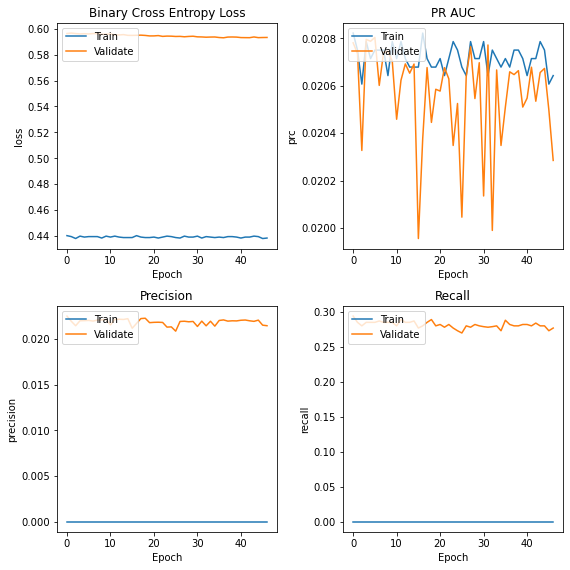

In [19]:
ev.plot_history(history)

### Increase batch size

In [12]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [14]:
LEARNING_RATE = 0.000001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-11 03:50:30.636203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4421 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207

2023-04-11 03:56:01.643675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.54400, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-01-prc0.02-tp21.0-loss0.54.hdf5
109/109 [==============================] - 440s 4s/step - loss: 0.4421 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5440 - val_tp: 21.0000 - val_fp: 992.0000 - val_tn: 5778.0000 - val_fn: 121.0000 - val_accuracy: 0.8390 - val_precision: 0.0207 - val_recall: 0.1479 - val_auc: 0.4522 - val_prc: 0.0190
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4428 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 2: val_loss did not improve from 0.54400
109/109 [==============================] - 424s 4s/step - loss: 0.4428 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

Process Keras_worker_ForkPoolWorker-1336:
Process Keras_worker_ForkPoolWorker-1314:
Process Keras_worker_ForkPoolWorker-1328:
Process Keras_worker_ForkPoolWorker-1339:
Process Keras_worker_ForkPoolWorker-1322:
Process Keras_worker_ForkPoolWorker-1335:
Process Keras_worker_ForkPoolWorker-1334:
Process Keras_worker_ForkPoolWorker-1329:
Process Keras_worker_ForkPoolWorker-1342:
Process Keras_worker_ForkPoolWorker-1317:
Process Keras_worker_ForkPoolWorker-1321:
Process Keras_worker_ForkPoolWorker-1343:
Process Keras_worker_ForkPoolWorker-1338:
Process Keras_worker_ForkPoolWorker-1337:
Process Keras_worker_ForkPoolWorker-1331:
Process Keras_worker_ForkPoolWorker-1344:
Process Keras_worker_ForkPoolWorker-1340:
Process Keras_worker_ForkPoolWorker-1325:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1332:
Process Keras_worker_ForkPoolWorker-1326:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1330:
Traceback (most recent call last):
Process Keras

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-ana

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


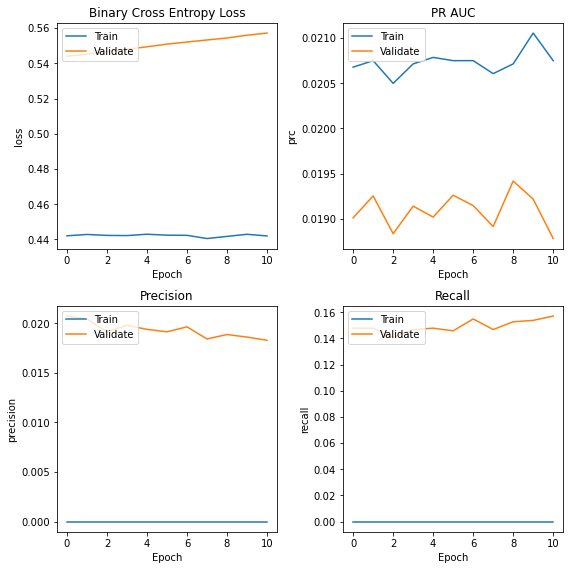

In [17]:
ev.plot_history(history)

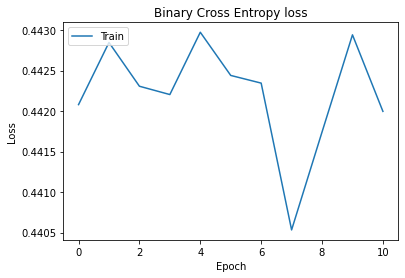

In [18]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

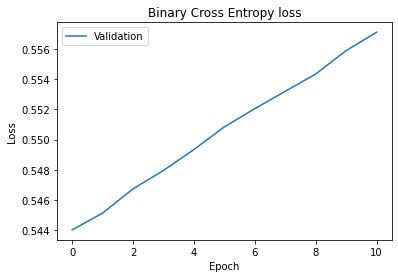

In [19]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

In [27]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 05:03:50.046527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4630 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4979 - prc: 0.0207

2023-04-09 05:09:32.592677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.58770, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-01-prc0.02-tp36.0-loss0.59.hdf5
109/109 [==============================] - 467s 4s/step - loss: 0.4630 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4979 - prc: 0.0207 - val_loss: 0.5877 - val_tp: 36.0000 - val_fp: 1596.0000 - val_tn: 5174.0000 - val_fn: 106.0000 - val_accuracy: 0.7538 - val_precision: 0.0221 - val_recall: 0.2535 - val_auc: 0.5409 - val_prc: 0.0241
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4596 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27329.0000 - fn: 575.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206
Epoch 2: val_loss did not improve from 0.58770
109/109 [==============================] - 432s 4s/step - loss: 0.4596 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

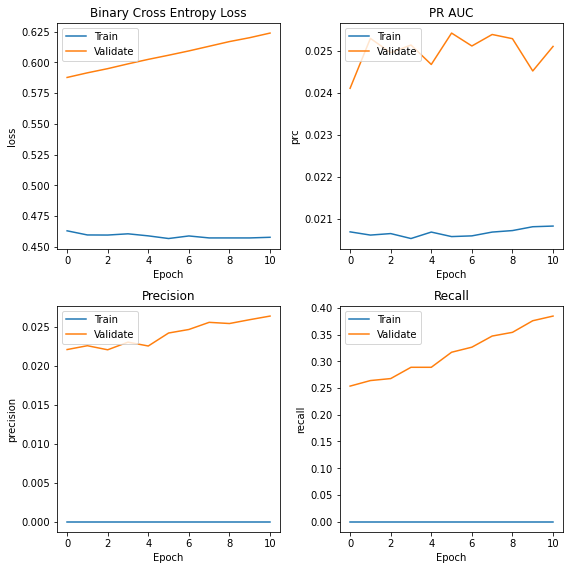

In [28]:
ev.plot_history(history)

## Plot gradient

In [16]:
%load_ext tensorboard

In [21]:
from keras.callbacks import TensorBoard
import os

log_basepath = '../logs'
model_name = 'imagenet_256_bias_weight_sgd-lr-1e-6'

model_log_path = log_basepath + model_name
os.makedirs(model_log_path, exist_ok=True)

tensorboard = TensorBoard(
    log_dir=model_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

In [18]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
)

LEARNING_RATE = 0.000001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-11-prc0.02-tp86.0-loss0.78.hdf5')

In [ ]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=30) #large batch may learn slower

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 11:08:42.877000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4388 - tp: 86.0000 - fp: 4210.0000 - tn: 29918.0000 - fn: 634.0000 - accuracy: 0.8610 - precision: 0.0200 - recall: 0.1194 - auc: 0.4985 - prc: 0.0208

2023-04-09 11:14:35.002929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.78492, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-01-prc0.02-tp87.0-loss0.78.hdf5
109/109 [==============================] - 492s 4s/step - loss: 0.4388 - tp: 86.0000 - fp: 4210.0000 - tn: 29918.0000 - fn: 634.0000 - accuracy: 0.8610 - precision: 0.0200 - recall: 0.1194 - auc: 0.4985 - prc: 0.0208 - val_loss: 0.7849 - val_tp: 87.0000 - val_fp: 4188.0000 - val_tn: 2581.0000 - val_fn: 56.0000 - val_accuracy: 0.3860 - val_precision: 0.0204 - val_recall: 0.6084 - val_auc: 0.4891 - val_prc: 0.0223
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 2: val_loss did not improve from 0.78492
109/109 [==============================] - 466s 4s/step - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.000

In [22]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=30) #large batch may learn slower

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

2023-04-09 21:38:12.682847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.4373 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27330.0000 - fn: 574.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206

2023-04-09 21:43:49.416731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.78480, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-01-prc0.02-tp85.0-loss0.78.hdf5
109/109 [==============================] - 453s 4s/step - loss: 0.4373 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27330.0000 - fn: 574.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206 - val_loss: 0.7848 - val_tp: 85.0000 - val_fp: 4189.0000 - val_tn: 2583.0000 - val_fn: 55.0000 - val_accuracy: 0.3860 - val_precision: 0.0199 - val_recall: 0.6071 - val_auc: 0.4881 - val_prc: 0.0216
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4366 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27332.0000 - fn: 572.0000 - accuracy: 0.9795 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0205
Epoch 2: val_loss did not improve from 0.78480
109/109 [==============================] - 435s 4s/step - loss: 0.4366 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

109/109 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206
Epoch 23: val_loss did not improve from 0.78404
109/109 [==============================] - 439s 4s/step - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206 - val_loss: 0.7848 - val_tp: 87.0000 - val_fp: 4187.0000 - val_tn: 2581.0000 - val_fn: 57.0000 - val_accuracy: 0.3860 - val_precision: 0.0204 - val_recall: 0.6042 - val_auc: 0.4870 - val_prc: 0.0223
Epoch 24/100
109/109 [==============================] - ETA: 0s - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 24: val_loss did not improve from 0.78404
109/109 [======

Epoch 46/100
109/109 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 46: val_loss did not improve from 0.78391
109/109 [==============================] - 438s 4s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.7842 - val_tp: 85.0000 - val_fp: 4182.0000 - val_tn: 2589.0000 - val_fn: 56.0000 - val_accuracy: 0.3869 - val_precision: 0.0199 - val_recall: 0.6028 - val_auc: 0.4884 - val_prc: 0.0220
Epoch 47/100
109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 47: val_loss did not improve from 0.78391
10

Epoch 69/100
109/109 [==============================] - ETA: 0s - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 69: val_loss improved from 0.78391 to 0.78364, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights__batch256_sgd-lr1e-6-69-prc0.02-tp85.0-loss0.78.hdf5
109/109 [==============================] - 423s 4s/step - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.7836 - val_tp: 85.0000 - val_fp: 4174.0000 - val_tn: 2596.0000 - val_fn: 57.0000 - val_accuracy: 0.3879 - val_precision: 0.0200 - val_recall: 0.5986 - val_auc: 0.4876 - val_prc: 0.0222
Epoch 70/100
109/109 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - acc

109/109 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206
Epoch 91: val_loss did not improve from 0.78345
109/109 [==============================] - 425s 4s/step - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206 - val_loss: 0.7844 - val_tp: 86.0000 - val_fp: 4184.0000 - val_tn: 2586.0000 - val_fn: 56.0000 - val_accuracy: 0.3866 - val_precision: 0.0201 - val_recall: 0.6056 - val_auc: 0.4886 - val_prc: 0.0221
Epoch 92/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 92: val_loss did not improve from 0.78345
109/109 [======

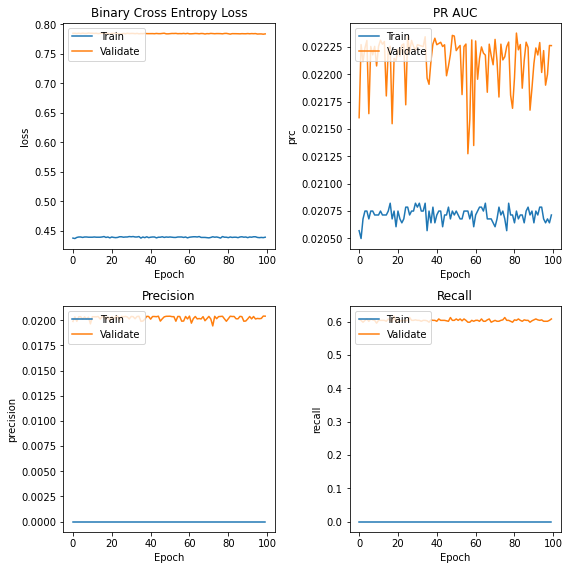

In [25]:
ev.plot_history(history)

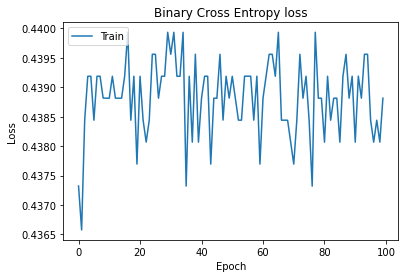

In [26]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()